In [83]:
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import re
#from nltk.stem.wordnet import WordNetLemmatizerLoad training dataset to Pandas and preview the top rows.

In [84]:
# load train data
data = pd.read_json('condensed_2018.json')
#data.columns = ['id','label','source','text']
data.head(2)
#get text and matching label columns
#data = data.drop(['id','source'],axis=1)
data.head(10)

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
0,2018-12-31 23:53:06,136012,1079888205351145472,NaN,False,33548,Twitter for iPhone,HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6
1,2018-12-31 20:02:52,65069,1079830268708556800,25073877.0,False,17456,Twitter for iPhone,"....Senator Schumer, more than a year longer t..."
2,2018-12-31 20:02:52,76721,1079830267274108928,NaN,False,21030,Twitter for iPhone,Heads of countries are calling wanting to know...
3,2018-12-31 15:39:15,127485,1079763923845419008,NaN,False,29610,Twitter for iPhone,It’s incredible how Democrats can all use thei...
4,2018-12-31 15:37:14,132439,1079763419908243456,NaN,False,30957,Twitter for iPhone,"I’m in the Oval Office. Democrats, come back f..."
5,2018-12-31 15:33:15,4217,1079762413589807104,NaN,False,1123,Twitter for iPhone,"I’m in the Oval Office. Democrats, come back f..."
6,2018-12-31 14:38:52,112735,1079748730058870784,NaN,False,25463,Twitter for iPhone,I am the only person in America who could say ...
7,2018-12-31 13:29:32,91523,1079731279032172544,NaN,False,22079,Twitter for iPhone,"I campaigned on Border Security, which you can..."
8,2018-12-31 13:19:13,72758,1079728684427341824,NaN,False,15152,Twitter for iPhone,.....Except the results are FAR BETTER than I ...
9,2018-12-31 13:12:40,101470,1079727034673311744,NaN,False,22119,Twitter for iPhone,...I campaigned on getting out of Syria and ot...


In [85]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['text'].apply(word_count)
data.head(5)

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,word count
0,2018-12-31 23:53:06,136012,1079888205351145472,NaN,False,33548,Twitter for iPhone,HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6,4
1,2018-12-31 20:02:52,65069,1079830268708556800,25073877.0,False,17456,Twitter for iPhone,"....Senator Schumer, more than a year longer t...",38
2,2018-12-31 20:02:52,76721,1079830267274108928,NaN,False,21030,Twitter for iPhone,Heads of countries are calling wanting to know...,41
3,2018-12-31 15:39:15,127485,1079763923845419008,NaN,False,29610,Twitter for iPhone,It’s incredible how Democrats can all use thei...,53
4,2018-12-31 15:37:14,132439,1079763419908243456,NaN,False,30957,Twitter for iPhone,"I’m in the Oval Office. Democrats, come back f...",44


In [86]:
# get most common words in training dataset
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
#Counter(all_words).most_common(10)

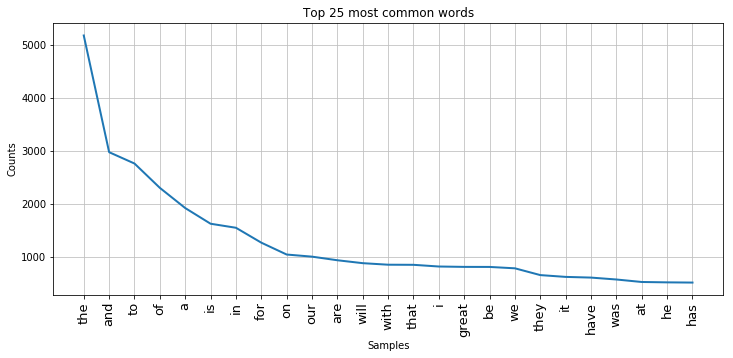

Text(0.5, 1.0, 'log-log plot of words frequency')

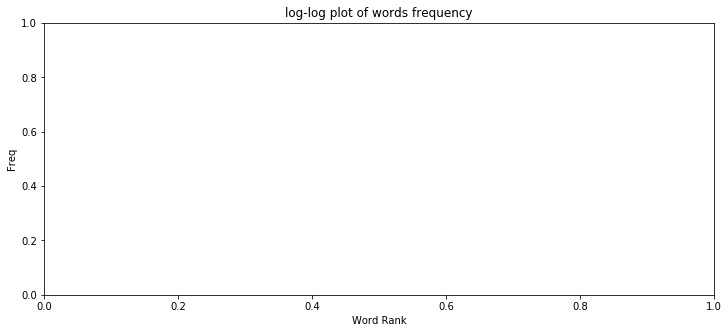

In [87]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)
# log-log plot
#word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
#plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

In [88]:
# create column names
col_names=['created_at','favorite_count','id_str','in_reply_to_user_id_str','is_retweet','retweet_count','source','text']
# read json
df_twtr = pd.read_json('condensed_2018.json')
# check head
df_twtr.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
0,2018-12-31 23:53:06,136012,1079888205351145472,NaN,False,33548,Twitter for iPhone,HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6
1,2018-12-31 20:02:52,65069,1079830268708556800,25073877.0,False,17456,Twitter for iPhone,"....Senator Schumer, more than a year longer t..."
2,2018-12-31 20:02:52,76721,1079830267274108928,NaN,False,21030,Twitter for iPhone,Heads of countries are calling wanting to know...
3,2018-12-31 15:39:15,127485,1079763923845419008,NaN,False,29610,Twitter for iPhone,It’s incredible how Democrats can all use thei...
4,2018-12-31 15:37:14,132439,1079763419908243456,NaN,False,30957,Twitter for iPhone,"I’m in the Oval Office. Democrats, come back f..."


In [89]:
# define punctuation
punctuation = !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~

# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________
# clean dataframe's text column
df_twtr['text'] = df_twtr['text'].apply(processTweet)
# preview some cleaned tweets
df_twtr['text'].head()

AttributeError: 'SList' object has no attribute 'replace'

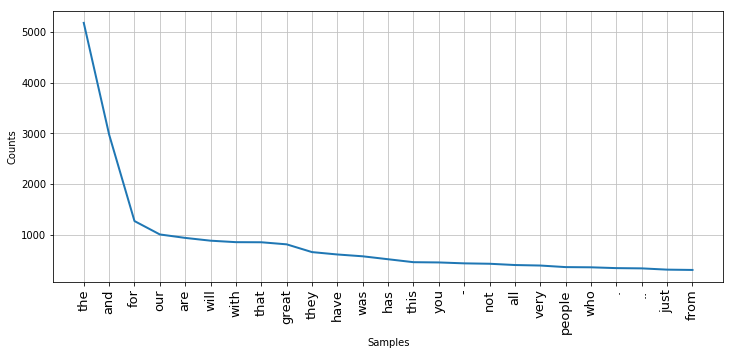

Text(0.5, 0, 'Word Rank')

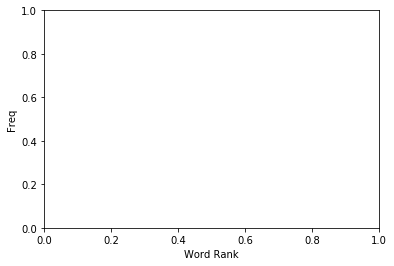

In [58]:
# most common words in twitter dataset
all_words = []
for line in list(df_twtr['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)
# log-log of all words 
#word_counts = sorted(Counter(all_words).values(), reverse=True)plt.figure(figsize=(12,5))
#plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

In [59]:
  import string
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]
def remove_words(word_list):
    remove = ['...','“','”','’','…']
    return [w for w in word_list if w not in remove]
# -------------------------------------------
# tokenize message column and create a column for tokens
df_twtr = df_twtr.copy() 
df_twtr['tokens'] = df_twtr['text'].apply(text_process) # tokenize style 1
df_twtr['no_democrats'] = df_twtr['tokens'].apply(remove_words) #tokenize style 2
df_twtr.head()


,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,tokens,no_democrats
0,2018-12-31 23:53:06,136012,1079888205351145472,NaN,False,33548,Twitter for iPhone,happy new year!,"[happy, new, year]","[happy, new, year]"
1,2018-12-31 20:02:52,65069,1079830268708556800,25073877.0,False,17456,Twitter for iPhone,"....senator schumer, more than year longer tha...","[senator, schumer, year, longer, administratio...","[senator, schumer, year, longer, administratio..."
2,2018-12-31 20:02:52,76721,1079830267274108928,NaN,False,21030,Twitter for iPhone,heads countries are calling wanting know why s...,"[heads, countries, calling, wanting, know, sen...","[heads, countries, calling, wanting, know, sen..."
3,2018-12-31 15:39:15,127485,1079763923845419008,NaN,False,29610,Twitter for iPhone,’ incredible how democrats can all use their r...,"[’, incredible, democrats, use, ridiculous, so...","[incredible, democrats, use, ridiculous, sound..."
4,2018-12-31 15:37:14,132439,1079763419908243456,NaN,False,30957,Twitter for iPhone,"’ the oval office. democrats, come back from v...","[’, oval, office, democrats, come, back, vacat...","[oval, office, democrats, come, back, vacation..."


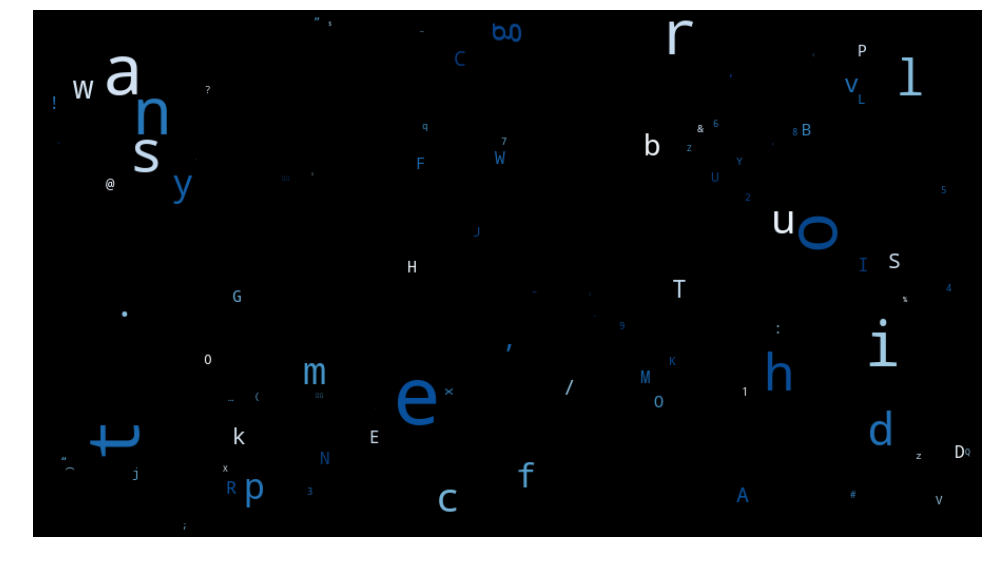

In [68]:
from wordcloud import WordCloud
from collections import Counter
# read json
df_twtr = pd.read_json('condensed_2018.json')
# split sentences to get individual words
all_words = []
for line in df_twtr['text']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [77]:
# vectorize (bag-of-words)
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_twtr['text'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))

10076


In [78]:
# example of vectorized text
sample_tweet = df_twtr['text'][111]
print(sample_tweet)
print('\n')

RT @realDonaldTrump: After historic victories against ISIS, it’s time to bring our great young people home! https://t.co/xoNjFzQFTp




In [79]:
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

  (0, 1210)	1
  (0, 3522)	1
  (0, 3783)	1
  (0, 3806)	1
  (0, 4705)	1
  (0, 5114)	1
  (0, 5132)	1
  (0, 6696)	1
  (0, 7252)	1
  (0, 7689)	1
  (0, 8794)	1
  (0, 9253)	1
  (0, 9647)	1




In [71]:
# transform the entire DataFrame of text
messages_bow = bow_transformer.transform(df_twtr['text'])
# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (3510, 10076)
Amount of Non-Zero occurences:  59865


In [72]:
# from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 9647)	0.32262264408079255
  (0, 9253)	0.3744214478782617
  (0, 8794)	0.20484034916573993
  (0, 7689)	0.15674683907790657
  (0, 7252)	0.2059805076093194
  (0, 6696)	0.16289869994698727
  (0, 5132)	0.2596232093332776
  (0, 5114)	0.31743080256672396
  (0, 4705)	0.4183751268354609
  (0, 3806)	0.2814737087644371
  (0, 3783)	0.298928246723144
  (0, 3522)	0.13011399924016492
  (0, 1210)	0.302507260273688


In [73]:
# some IDF (inverse document frequency) example
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['trump']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['democrats']])

3.622392631010006
3.5615373552887313


In [74]:
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(3510, 10076)
